In [1]:
%config IPCompleter.greedy=True

# En este módulo se realiza la limpieza de datos y se exportan dentro de este mismo directorio "Clean datasets"

#### Imports

In [2]:
import pandas as pd
import numpy as np
from numpy import isnan
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

## Carga de data set
Dataset obtenido en http://medata.gov.co/dataset/intento-de-suicidio

Como primera tarea y antes de cargar los datos, fueron borrados manualmente(editor de texto) todos aquellos valores que se presetaran como SD(sin datos) para facilitar el procesado de los datos en siguientes pasos. SD-> null (nan)

Ya cargados los datos se procede a cambiar los titulos del dataset, ya que originalmente todos incluian el nombre de la base de datos, esto con el fin de trabajar con mayor facilidad



In [3]:
df_suicidio=pd.read_csv("sivigila_intsuicidio.csv", delimiter = ';')
# df_suicidio.info()

titles = df_suicidio.columns
arr = []
for i in titles:
    arr.append(i[21:]) #Eliminar 'sivigila_intsuicidio.'
    
df_suicidio.columns = arr
# df_suicidio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11336 entries, 0 to 11335
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sivigila_intsuicidio.id                  11336 non-null  int64  
 1   sivigila_intsuicidio.semana              11336 non-null  int64  
 2   sivigila_intsuicidio.edad_               11336 non-null  float64
 3   sivigila_intsuicidio.uni_med_            11336 non-null  int64  
 4   sivigila_intsuicidio.sexo_               11336 non-null  object 
 5   sivigila_intsuicidio.nombre_barrio       11336 non-null  object 
 6   sivigila_intsuicidio.comuna              11336 non-null  object 
 7   sivigila_intsuicidio.tipo_ss_            11334 non-null  object 
 8   sivigila_intsuicidio.cod_ase_            11336 non-null  object 
 9   sivigila_intsuicidio.fec_con_            11336 non-null  object 
 10  sivigila_intsuicidio.ini_sin_            11336

,id,semana,edad_,uni_med_,sexo_,nombre_barrio,comuna,tipo_ss_,cod_ase_,fec_con_,...,inmolacion,lanz_vacio,lanz_vehic,lanz_agua,intoxicaci,gp_psiquia,psiquiatri,trab_socia,evento,year_
0,1,49,22.0,1,F,Santo Domingo Savio No.1,Popular,S,CCF002,08/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
1,2,49,19.0,1,M,Villa Hermosa,Villa Hermosa,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
2,3,49,52.0,1,F,Los Conquistadores,Laureles,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
3,4,49,58.0,1,F,Las Violetas,Belen,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
4,5,49,32.0,1,M,Florida Nueva,Laureles,C,EPS010,06/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11331,11332,48,17.0,1,F,Pajarito,Robledo,S,CCF002,05/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11332,11333,48,16.0,1,F,Manrique Central No.1,Aranjuez,P,RES001,30/11/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11333,11334,48,16.0,1,F,Barrios de Jesus,Buenos Aires,C,EPS010,04/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11334,11335,49,23.0,1,F,Moravia,Aranjuez,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015


## Eliminar columnas no relevantes para el problema
Muy relacionado con las entradas y salidas definidas.

Inicialmente se habia propuesto predecir la posibilidad de que una persona intentara el suicidio basados en unas condiciones previas, pero para realizar esto necesitariamos de datos de caracterizacion de personas que no han intentado el suicidio, el dataset con el que se esta trabajando para el caso exactyo de medellin no presenta esta condicion, solo presenta informacion de personas que ya han intentado suicidarse, por lo que debemos replantear un poco lo que se va a predecir(salida).

Al realizar el analisis de los datos presentes en el dataset se decidio tomar como salida la columna 'inten_prev', la cual hace referencia a si la persona ha intentado previemente el suicidio , lo cual sera predecido a partir de las condiciones previas['prob_parej', 'enfermedad_cronica',  'prob_econo', 'muerte_fam', 'esco_educ', 'prob_legal', 'suici_fm_a', 'maltr_fps', 'prob_labor', 'prob_consu', 'hist_famil', 'idea_suici', 'plan_suici', 'antec_tran', 'tran_depre', 'trast_personalidad', 'trast_bipolaridad', 'esquizofre', 'antec_v_a', 'abuso_alco',]

La decision de tomar como salida 'intent_prev' se define en aras de no alejarse mucho del probelam prpuesto incialmente, ademas se descubrio que una columna muy parecida 'intentos' no podia ser usada, ya que aproximadamente el 85% eran valores nulos


Para este caso no es relevante la forma de intento de suicidio por lo que se eliminaran las columnas ['ahorcamien','arma_corto','arma_fuego','inmolacion','lanz_vacio','lanz_vehic','lanz_agua','intoxicaci'], adicionalmente no son de interes para el problema las columnas ['id','cod_ase_','tip_cas_', 'pac_hos_', 'nombre_barrio', 'comuna'], tampoco hay especial interes en las fechas por lo que se eliminaran ['semana', 'fec_con_', 'ini_sin_', 'fec_ocurr', 'year_']. ['uni_med_', 'evento'] se eliminan ya que solo 1 resgistro tiene un valor diferente  y en el caso del segundo, solo hay un valor posible. Finalmente la columna ['intentos'] presenta un alto porcentaje de valores nulos por lo que tambien se eliminara


Las columnas que quedan son aquellas que inicialmente se pretendian usar como entrada y algunas adicionales las cuales se exploraran para descubrir si existe alguna correlacion o si son relevantes para la salida buscada



In [4]:
# for column in df_suicidio.columns:
#     print(df_suicidio[column].value_counts(dropna=False))

2047     1
1338     1
3347     1
1298     1
7441     1
        ..
629      1
2676     1
8817     1
10864    1
2049     1
Name: id, Length: 11336, dtype: int64
38    270
47    267
18    253
14    252
28    250
41    250
39    246
30    243
10    242
36    241
31    236
16    236
12    234
9     233
20    233
35    229
33    228
17    227
32    227
43    227
19    226
42    223
50    221
44    219
13    218
46    218
29    216
34    216
37    214
8     212
15    212
40    211
22    210
23    210
24    210
21    207
51    205
25    205
48    204
7     204
45    203
52    202
49    196
11    195
27    194
5     194
6     191
26    191
3     168
1     167
4     166
2     162
53     22
Name: semana, dtype: int64
15.0    683
17.0    677
16.0    661
14.0    614
18.0    582
       ... 
85.0      2
88.0      2
82.0      2
6.0       1
83.0      1
Name: edad_, Length: 83, dtype: int64
1    11335
2        1
Name: uni_med_, dtype: int64
F     7411
M     3925
Name: sexo_, dtype: int64
SIN INFORMACION

In [5]:
# for column in df_suicidio.columns:    
#     print(column)
#     print(df_suicidio[column].unique())

id
[    1     2     3 ... 11334 11335 11336]
semana
[49  5 50 51 52  6  7  8  9 13 34 16 41 14 39 38 36  2 17 35 25 23 37 15
 18 24 48 43 19 32  4  1 47 28  3 44 33 12 40 30 20 10 46 31 42 26 29 21
 45 11 22 27 53]
edad_
[22. 19. 52. 58. 32. 50. 18. 29. 12. 14. 13. 17. 27. 21. 23. 20. 25. 33.
 30. 61. 57. 51. 44. 49. 41. 15. 16. 26. 36. 34. 28. 47. 24. 48. 56. 35.
 42. 54. 53. 11. 45. 59. 31.  9.  7.  8. 10. 38. 37. 68. 39. 55. 76. 62.
 46. 74. 70. 82. 40. 64. 43. 73. 66. 65. 63. 83. 60. 79. 77. 86. 87. 88.
 71. 80. 69. 89. 67. 85. 78. 75. 81. 72.  6.]
uni_med_
[1 2]
sexo_
['F ' 'M ']
nombre_barrio
['Santo Domingo Savio No.1' 'Villa Hermosa' 'Los Conquistadores'
 'Las Violetas' 'Florida Nueva' 'Castilla' 'Doce de Octubre No.1' 'Boston'
 'San Martin de Porres' 'Nuevos Conquistadores' 'Carlos E. Restrepo'
 'Blanquizal' 'Los Balsos No.2' 'San Lucas' 'Kennedy'
 'San Antonio de Prado' 'El Compromiso' 'La Francia' 'El Pinal' 'Popular'
 'Santa Margarita' 'Corregimiento de Santa Elena' 'Graniz

### Nota
Fue necesario cambiar adicionalmente los valores = 14 en escolaridad para dejarlos como nulos(sin informacion)

In [6]:
df_suicidio['escolarid'].replace({ 14: np.NaN }, inplace=True)

In [7]:
df_suicidio['escolarid'].unique()

array([nan,  3.,  2.,  9.,  1.,  5.,  8., 13.,  7.,  4., 12., 10., 11.,
        6.])

In [8]:
df_suicidio = df_suicidio.drop(['intentos','ahorcamien','arma_corto','arma_fuego','inmolacion','lanz_vacio','lanz_vehic','lanz_agua','intoxicaci',
                                'id','cod_ase_','tip_cas_', 'pac_hos_', 'nombre_barrio', 'comuna', 'semana', 'fec_con_', 'ini_sin_', 'fec_ocurr',
                                'year_', 'uni_med_', 'evento'], axis= 1)
df_suicidio.info()

columns_number = len(df_suicidio.columns)
numeric_cols = df_suicidio.select_dtypes(include=[np.number]).columns.values
print('Numeric cols:' + str(len(numeric_cols)))

non_numeric_cols = df_suicidio.select_dtypes(exclude=[np.number]).columns.values
print('Non numeric cols:' + str(len(non_numeric_cols)))
print(non_numeric_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11336 entries, 0 to 11335
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   edad_               11336 non-null  float64
 1   sexo_               11336 non-null  object 
 2   tipo_ss_            11334 non-null  object 
 3   inten_prev          4464 non-null   float64
 4   estado_civ          4154 non-null   float64
 5   escolarid           3742 non-null   float64
 6   prob_parej          4466 non-null   float64
 7   enfermedad_cronica  4466 non-null   float64
 8   prob_econo          4154 non-null   float64
 9   muerte_fam          4154 non-null   float64
 10  esco_educ           4154 non-null   float64
 11  prob_legal          4466 non-null   float64
 12  suici_fm_a          4154 non-null   float64
 13  maltr_fps           4154 non-null   float64
 14  prob_labor          4154 non-null   float64
 15  prob_consu          4466 non-null   float64
 16  hist

## Datos faltantes

#### Heatmap de datos faltantes
Se observa que desde intento_previo hasta trab_social la cantidad de datos faltantes es muy alta 

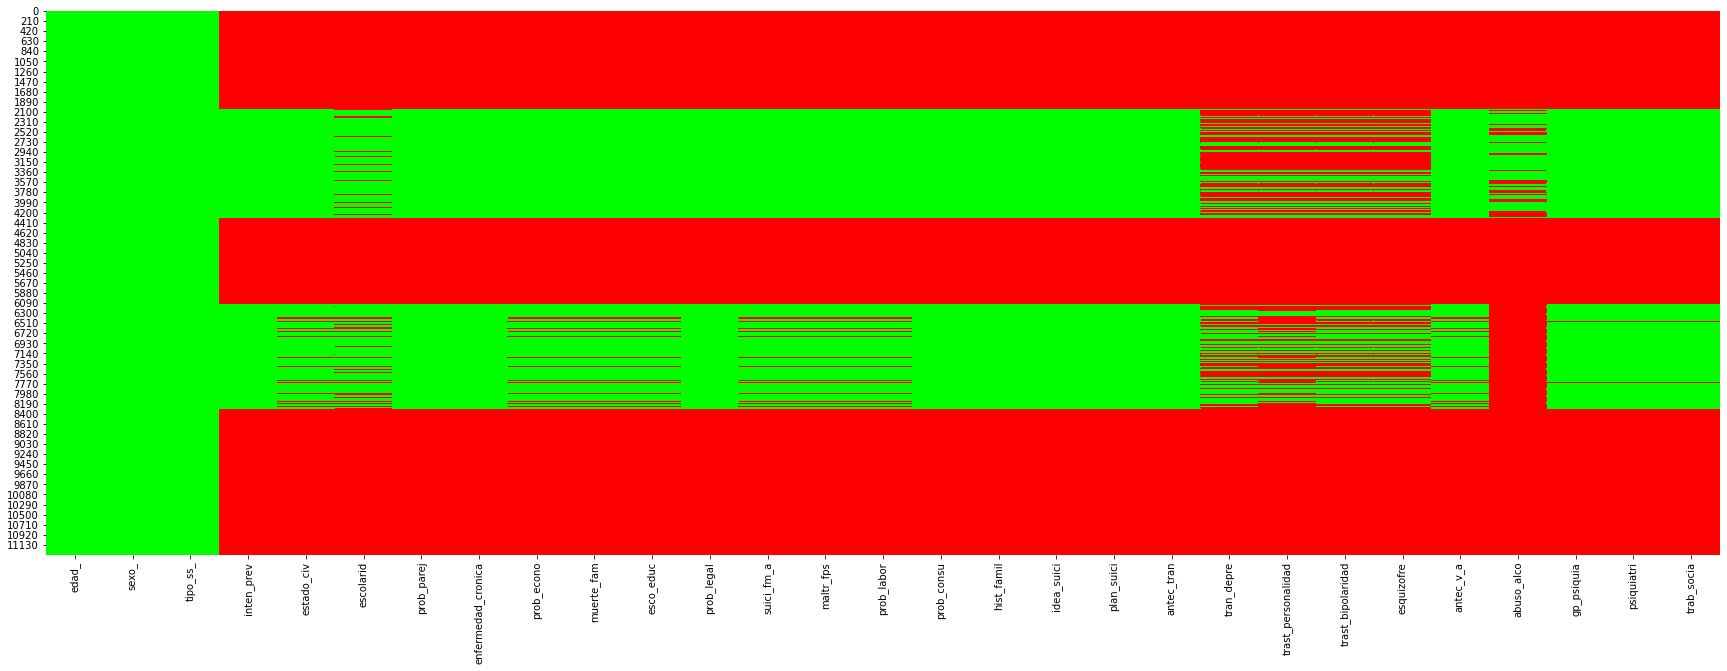

In [9]:
cols = df_suicidio.columns[:]
colours = ['#00FF00', '#ff0000'] # specify the colours - red is missing. green is not missing.
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
sns.heatmap(df_suicidio[cols].isnull(), cmap=sns.color_palette(colours), ax=ax,cbar=False)

#### Porcentaje de datos faltantes

In [10]:
for col in df_suicidio.columns:
    pct_missing = np.mean(df_suicidio[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

tipo_ss_ - 0.02%
inten_prev - 60.62%
estado_civ - 63.36%
escolarid - 66.99%
prob_parej - 60.6%
enfermedad_cronica - 60.6%
prob_econo - 63.36%
muerte_fam - 63.36%
esco_educ - 63.36%
prob_legal - 60.6%
suici_fm_a - 63.36%
maltr_fps - 63.36%
prob_labor - 63.36%
prob_consu - 60.6%
hist_famil - 60.6%
idea_suici - 60.6%
plan_suici - 60.6%
antec_tran - 60.61%
tran_depre - 81.53%
trast_personalidad - 84.38%
trast_bipolaridad - 81.53%
esquizofre - 81.52%
antec_v_a - 63.36%
abuso_alco - 85.41%
gp_psiquia - 61.44%
psiquiatri - 61.46%
trab_socia - 61.46%


#### Conteo de registros agrupados por datos faltantes

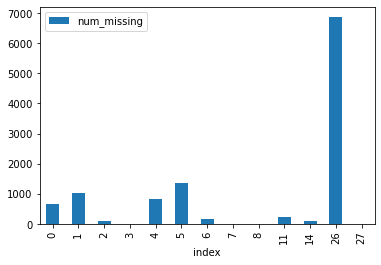

In [11]:
# first create missing indicator for features with missing data
for col in df_suicidio.columns:
    missing = df_suicidio[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
#         print('created missing indicator for: {}'.format(col))
        df_suicidio['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df_suicidio.columns if 'ismissing' in col]
df_suicidio['num_missing'] = df_suicidio[ismissing_cols].sum(axis=1)

df_suicidio['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

## Solucion
### 1. Eliminar registros con 11 o mas datos faltantes
### 2. Eliminar registros con informacion faltante en 'inten_prev'
### 3. Tratar columna con alto porcentaje de nulos, ya sea eliminandolas o imputando datos


In [12]:
# drop rows with a lot of missing values.
ind_missing = df_suicidio[df_suicidio['num_missing'] >= 11].index
df2 = df_suicidio.drop(ind_missing, axis=0)
# df2.info()

## Previamente el filtro se estaba haciendo asi:
# df_filtered = df_suicidio[df_suicidio['fec_ocurr'] != '01/01/1900'] 
# aux2 =df_filtered
# aux2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4154 entries, 2048 to 8315
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad_                         4154 non-null   float64
 1   sexo_                         4154 non-null   object 
 2   tipo_ss_                      4154 non-null   object 
 3   inten_prev                    4152 non-null   float64
 4   estado_civ                    4154 non-null   float64
 5   escolarid                     3742 non-null   float64
 6   prob_parej                    4154 non-null   float64
 7   enfermedad_cronica            4154 non-null   float64
 8   prob_econo                    4154 non-null   float64
 9   muerte_fam                    4154 non-null   float64
 10  esco_educ                     4154 non-null   float64
 11  prob_legal                    4154 non-null   float64
 12  suici_fm_a                    4154 non-null   float64
 13  

In [13]:
df2['inten_prev'].value_counts(dropna=False)

2.0    2548
1.0    1603
NaN       2
4.0       1
Name: inten_prev, dtype: int64

In [14]:
df2 = df2[df2['inten_prev'].notnull()]
df2 = df2[df2['inten_prev'] != 4] # 4 equivale a sin informacion, por lo tanto se elimina para contar en trodos los registros con un valor valido
# df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4151 entries, 2048 to 8315
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad_                         4151 non-null   float64
 1   sexo_                         4151 non-null   object 
 2   tipo_ss_                      4151 non-null   object 
 3   inten_prev                    4151 non-null   float64
 4   estado_civ                    4151 non-null   float64
 5   escolarid                     3739 non-null   float64
 6   prob_parej                    4151 non-null   float64
 7   enfermedad_cronica            4151 non-null   float64
 8   prob_econo                    4151 non-null   float64
 9   muerte_fam                    4151 non-null   float64
 10  esco_educ                     4151 non-null   float64
 11  prob_legal                    4151 non-null   float64
 12  suici_fm_a                    4151 non-null   float64
 13  

#### Revisamos los datos de nuevo

5    1355
1    1036
4     834
0     655
6     178
2      86
7       4
3       2
8       1
Name: num_missing, dtype: int64

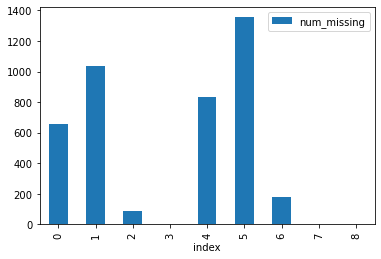

In [15]:
df2['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')
# df2['num_missing'].value_counts(dropna=False)

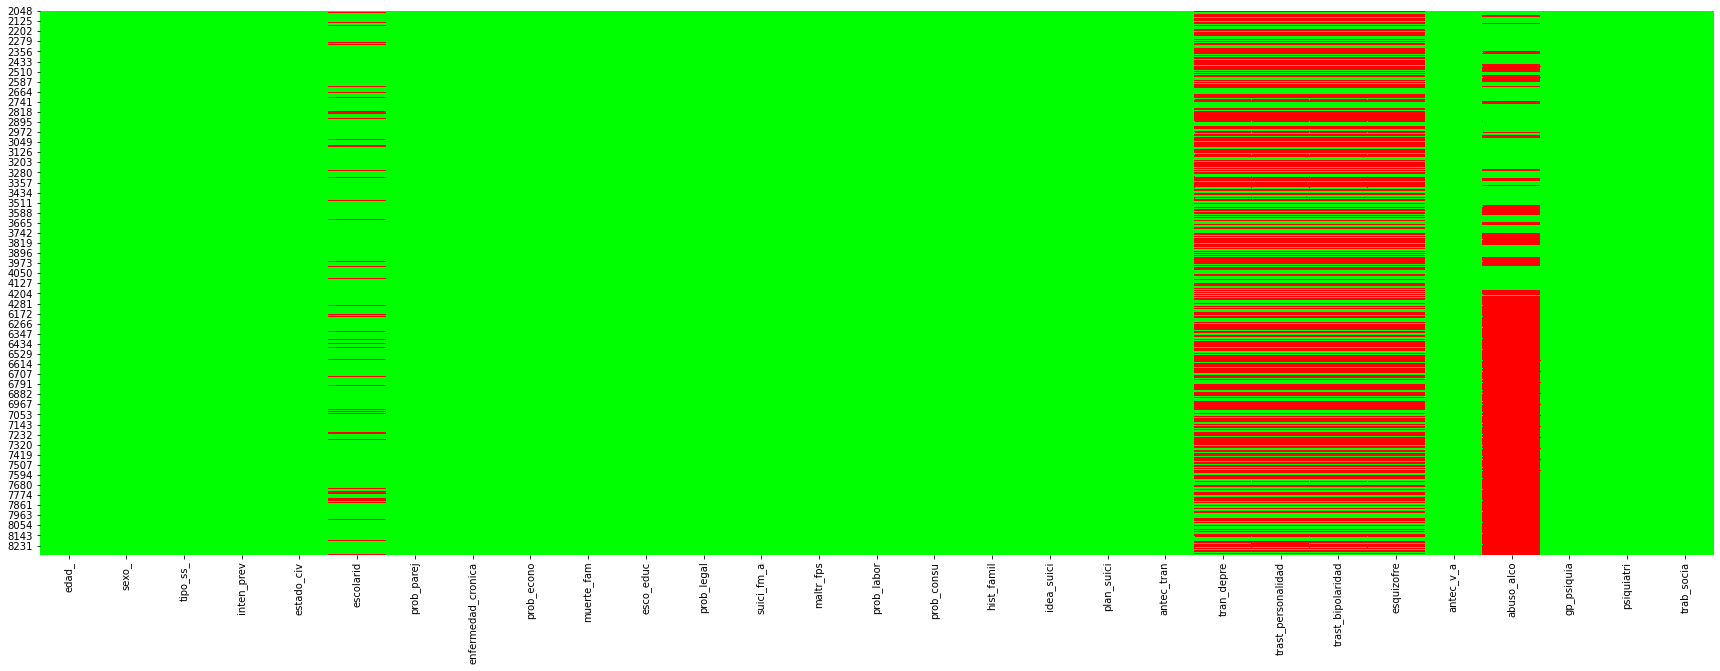

In [16]:
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
cols = df2.columns[:columns_number]
sns.heatmap(df2[cols].isnull(), cmap=sns.color_palette(colours), ax=ax, cbar=False)

In [17]:
for col in df2.columns:
    pct_missing = np.mean(df2[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

escolarid - 9.93%
tran_depre - 57.12%
trast_personalidad - 57.38%
trast_bipolaridad - 57.12%
esquizofre - 57.12%
abuso_alco - 60.23%
gp_psiquia - 0.14%
psiquiatri - 0.19%
trab_socia - 0.19%


In [18]:
# df2.iloc[:,:columns_number]

,edad_,sexo_,tipo_ss_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,...,antec_tran,tran_depre,trast_personalidad,trast_bipolaridad,esquizofre,antec_v_a,abuso_alco,gp_psiquia,psiquiatri,trab_socia
2048,24.0,F,S,1.0,2.0,3.0,1.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2049,30.0,M,S,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,1.0
2050,20.0,F,C,1.0,1.0,9.0,2.0,2.0,2.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
2051,23.0,F,S,2.0,1.0,3.0,1.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,2.0
2052,62.0,M,S,2.0,2.0,NaN,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,17.0,F,C,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,2.0
8311,17.0,F,C,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0
8312,17.0,F,C,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,2.0,2.0
8313,17.0,F,C,2.0,1.0,9.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0


### Nota
En este punto nos presentamos ante tres opciones: 
1. Eliminar aquella columnas que presentan alto numero de valores nulos (tran_depre, trast_personalidad, trast_bipolaridad, esquizofre, abuso_alco), ya que al ser tan altos no seria razonable imputar datos
2. Depurar aun mas los datos y reducir "drasticamente" el volumne de resgistros con respecto al original pero conservando algunas caracteristicas que consideramos podrian ser relevantes para la prediccion 
3. Imputar dichos valores nulos, aun cuando son mayoria

Se obtendran tres datasets(cds_few, cds, cds_imputed), cada uno aplicando una opcion, para comparalrlos en siguientes etapas al desarrrollar los modelos.

Primero se procede a detectar outliers, valores no validos y terminar de etiquetar y limpiar los datos para que lo uiltom a realizar sea separarlo segun se comento anteriormente.

## Deteccion de outliers y valores no validos
El unico dato realmente numerico es edad, en su diagrama de cajase observaque hya alguno valores muy alejados del promedio, pero segun lo que significa para el contexto los coonsideramos como validos

Para las demas columnas(categoricas) se realiza la grafica de barra para conocer su distribucion y si existe algun dato no valido. Tal es el caso para 'escolarid', en el cual se presentan algunas con valor en 6, estos registros se proceden a eliminar


edad_


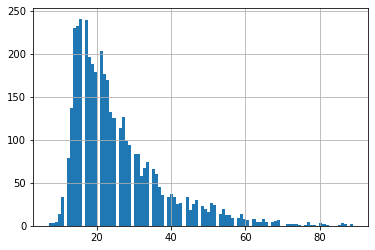

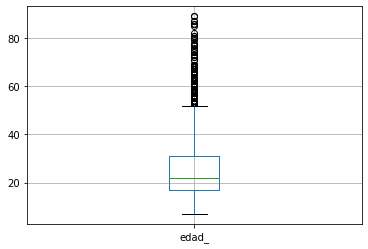

sexo_


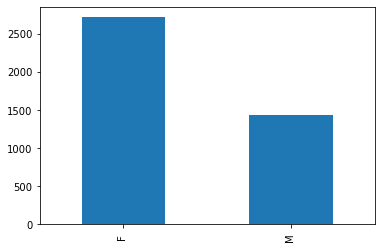

tipo_ss_


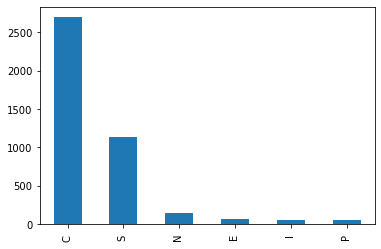

inten_prev


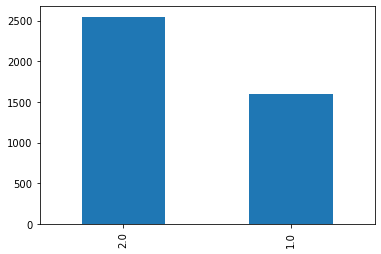

estado_civ


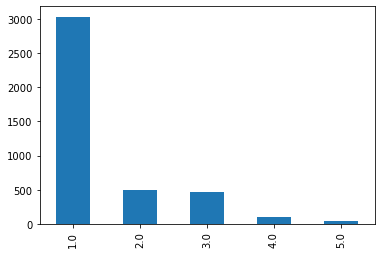

escolarid


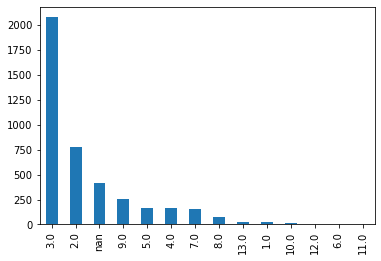

prob_parej


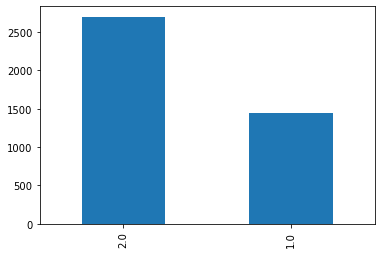

enfermedad_cronica


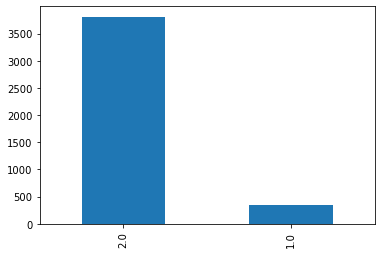

prob_econo


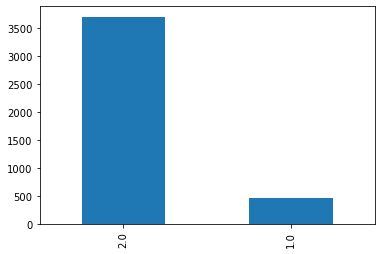

muerte_fam


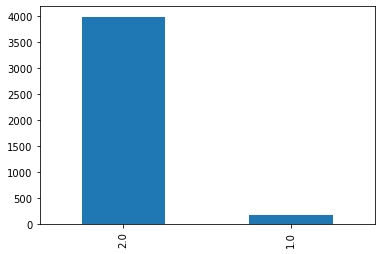

esco_educ


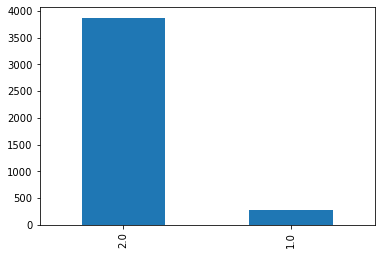

prob_legal


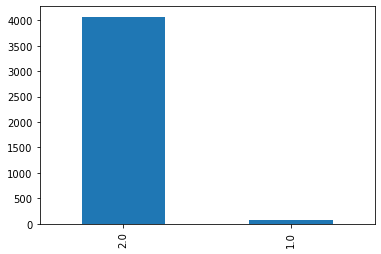

suici_fm_a


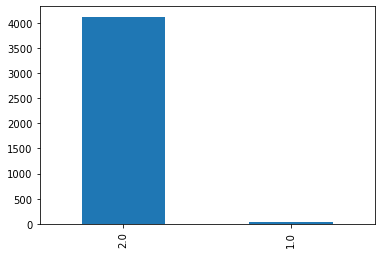

maltr_fps


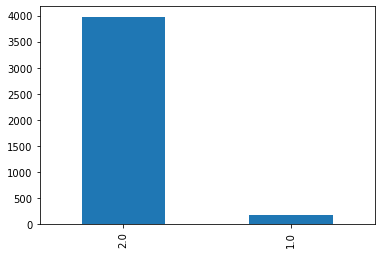

prob_labor


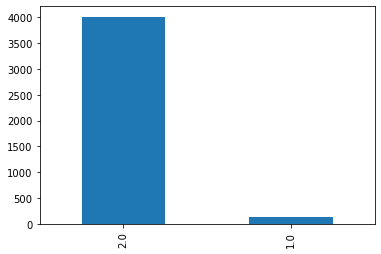

prob_consu


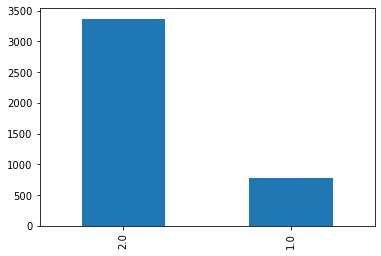

hist_famil


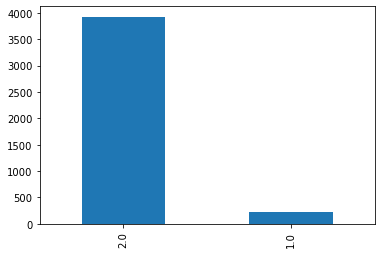

idea_suici


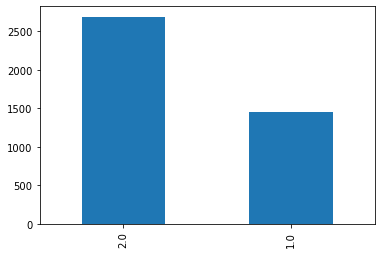

plan_suici


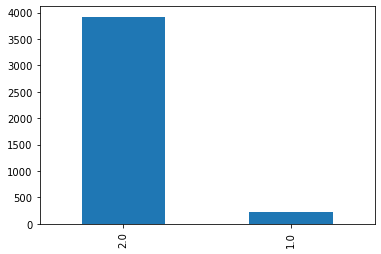

antec_tran


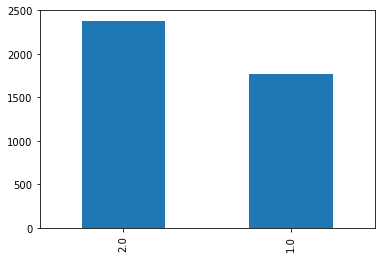

tran_depre


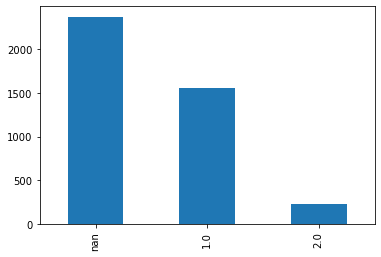

trast_personalidad


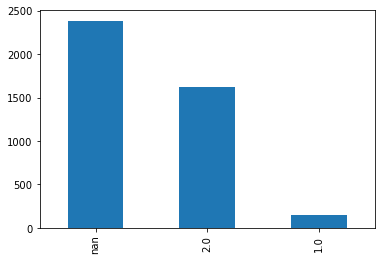

trast_bipolaridad


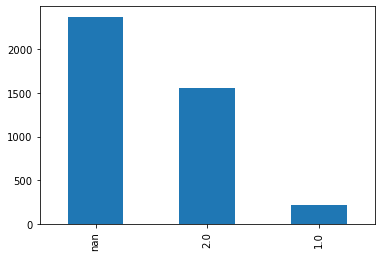

esquizofre


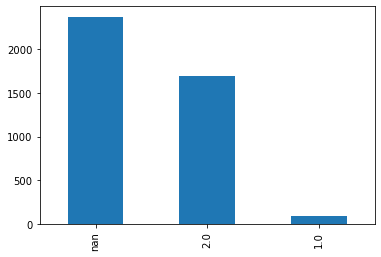

antec_v_a


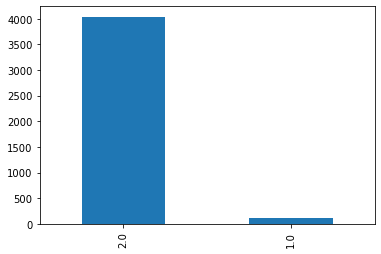

abuso_alco


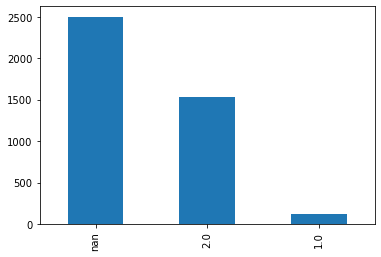

gp_psiquia


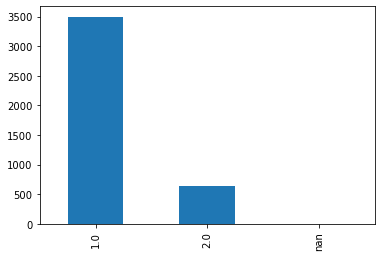

psiquiatri


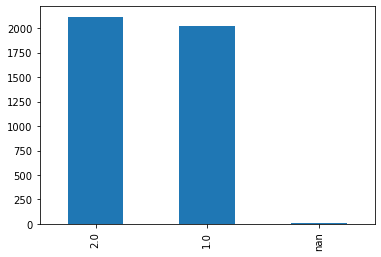

trab_socia


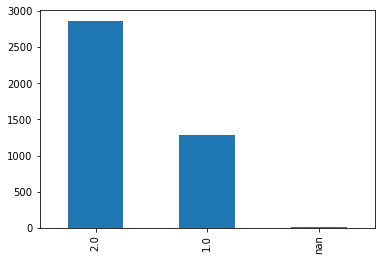

In [19]:
print('edad_')
df2['edad_'].hist(bins=100)
plt.plot()
plt.show()
df2.boxplot(column=['edad_'])
plt.plot()
plt.show()
# for col in df2.columns:
#     if( col[-7:] != 'missing' and col != 'edad_'):
#         print(col)
#         df2[col].value_counts(dropna= False).plot.bar()
#         plt.plot()
#         plt.show()

In [20]:
df2 = df2[df2['escolarid'] != 6] #Segun la documentacion del data set, 6 no es posible en esta columna

## Labeling- Encoding
Inicialmente los valores posibles que tienen las columnas son:

'edad_' -> numero

'sexo_' -> M, F

'tipo_ss_' -> C= Contributivo, S=Subsidiado, P=Excepción, E=Especial, N= No asegurado, I= Indeterminado/Pendiente

'estado_civ' -> 1= Soltero(a), 2=Casado(a), 3= Unión libre, 4= Viudo(a), 5= Divorciado(a)

'escolarid' -> 1= Preescolar, 2= Básica primaria, 3= Básica secundaria, 5= Media técnica, 7= Técnica profesional, 8= Tecnológica o técnica, 9= Profesional, 10= Especialización, 11= Maestría, 12= Doctorado, 13= Ninguno, 14= Sin información

['inten_prev', 'prob_parej', 'enfermedad_cronica', 'prob_econo', 'muerte_fam', 'esco_educ', 'prob_legal', 'suici_fm_a', 'maltr_fps', 'prob_labor', 'prob_consu', 'hist_famil', 'idea_suici', 'plan_suici', 'antec_tran', 'tran_depre', 'trast_personalidad', 'trast_bipolaridad', 'esquizofre', 'antec_v_a', 'abuso_alco', 'gp_psiquia', 'psiquiatri', 'trab_socia'] -> 1= Si, 2= No

La mayoria de columna son categoricas, pero el dataset obtenido ya las tenia codificadas, por lo tanto se usara asi, pero donde sea necesario se cambiaran algunas etiquetas y se codificaran aquellas que lo necesiten

'sexo_'-> binary encoding M:0 F:1

'tipo_ss_'-> se utilizara one hot encoding

Las demas se usaran tsal y como estan

In [21]:
nominal_features = pd.get_dummies(df2['tipo_ss_'], prefix="tipo_ss")
# nominal_features

,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2048,0,0,0,0,0,1
2049,0,0,0,0,0,1
2050,1,0,0,0,0,0
2051,0,0,0,0,0,1
2052,0,0,0,0,0,1
...,...,...,...,...,...,...
8309,1,0,0,0,0,0
8311,1,0,0,0,0,0
8312,1,0,0,0,0,0
8313,1,0,0,0,0,0


In [22]:
df2['sexo_'].replace({'M':0, 'F':1}, inplace= True,  regex=True)
df2 = df2.join(nominal_features)
df2 = df2.drop('tipo_ss_', axis=1)
# df2

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,gp_psiquia_ismissing,psiquiatri_ismissing,trab_socia_ismissing,num_missing,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2048,24.0,1,1.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,...,False,False,False,4,0,0,0,0,0,1
2049,30.0,0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,False,False,False,4,0,0,0,0,0,1
2050,20.0,1,1.0,1.0,9.0,2.0,2.0,2.0,1.0,2.0,...,False,False,False,0,1,0,0,0,0,0
2051,23.0,1,2.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,...,False,False,False,4,0,0,0,0,0,1
2052,62.0,0,2.0,2.0,NaN,2.0,2.0,1.0,2.0,2.0,...,False,False,False,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,...,False,False,False,1,1,0,0,0,0,0
8311,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,...,False,False,False,5,1,0,0,0,0,0
8312,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,...,False,False,False,5,1,0,0,0,0,0
8313,17.0,1,2.0,1.0,9.0,2.0,2.0,2.0,2.0,1.0,...,False,False,False,5,1,0,0,0,0,0


### Imputacion 
A las columnas [gp_psiquia, psiquiatri, trab_socia] se les realiza una imputacion simple de datos usando la mediana

In [23]:
impute = ['gp_psiquia', 'psiquiatri', 'trab_socia']
for col in impute:    
    med = df2[col].median()
    df2[col] = df2[col].fillna(med)

In [24]:
for col in df2.columns:
    pct_missing = np.mean(df2[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

escolarid - 9.94%
tran_depre - 57.09%
trast_personalidad - 57.36%
trast_bipolaridad - 57.09%
esquizofre - 57.09%
abuso_alco - 60.18%


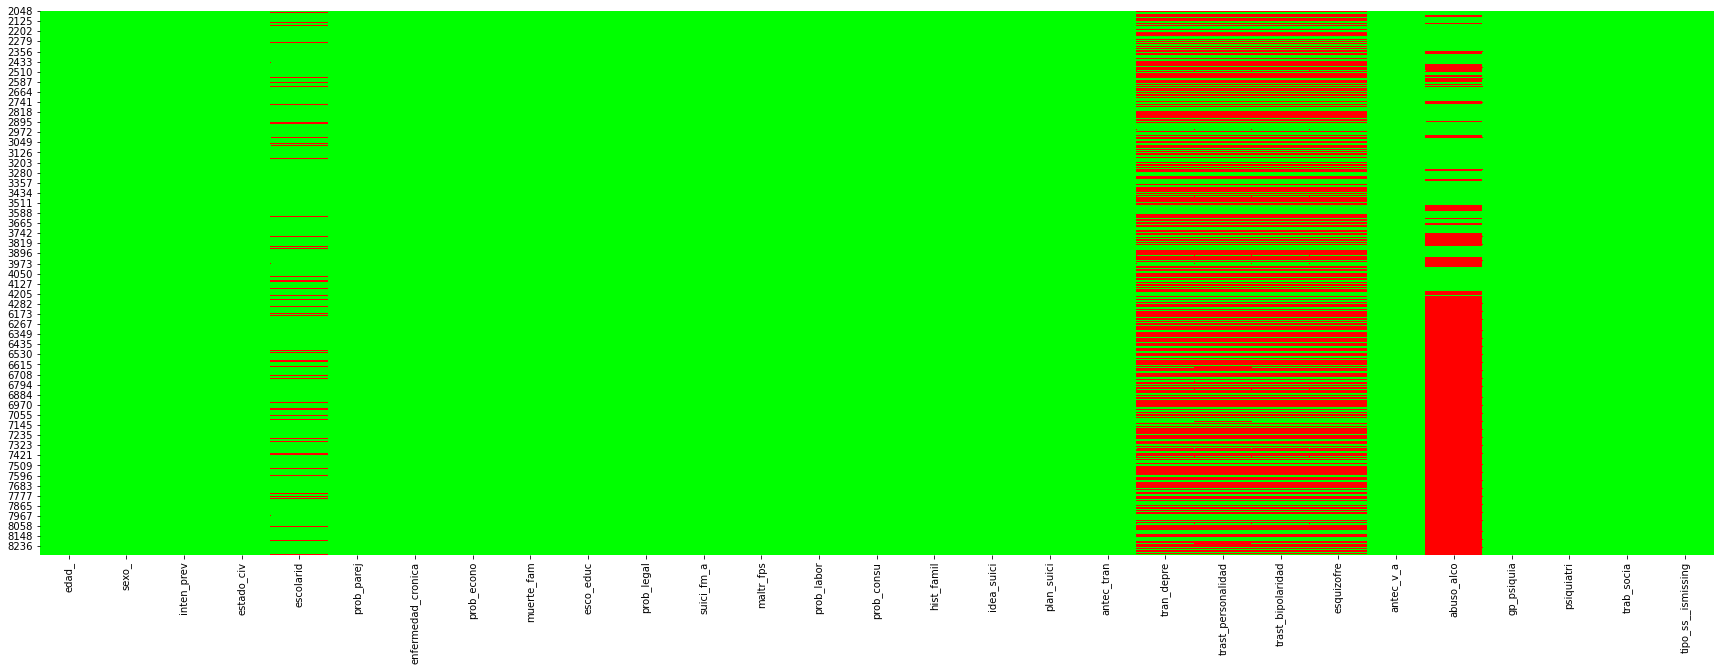

In [25]:
# fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
# cols = df2.columns[:columns_number]
# sns.heatmap(df2[cols].isnull(), cmap=sns.color_palette(colours), ax=ax, cbar=False)

### Obtencion de cds_imputed e imputacion para escolarid
~~Se realizara una imputacion iterativa(multivariante i.e. se tienen en cuenta las otras columnas para imputar), desde aqui saldra el dataset cds_imputed, y adicionalmente tomaremos la columna escolarid para los otros dos data set.~~

Se abandona el enfoque multivariante ya que no se logro imputar con tecnica de mayor frecuencia,moda o mediana, por lo que los valores imputados poian resultar siendo decimales, lo cual no tendria sentido al ser datos categoricos.

Enfoque univariante

In [26]:
##No da solo enteros
# imputer = KNNImputer()
# imputer.fit(df2)
# Xtrans0 = imputer.transform(df2)
# cds_imputed = pd.DataFrame(Xtrans0, columns = df2.columns)
# cds_imputed

##No da solo enteros
# imputer = IterativeImputer(initial_strategy='most_frequent')
# # fit on the dataset
# imputer.fit(df2)
# # transform the dataset
# Xtrans = imputer.transform(df2)
# cds_imputed = pd.DataFrame(Xtrans, columns = df2.columns)
# cds_imputed

# to_round = ['escolarid', 'tran_depre', 'trast_personalidad', 'trast_bipolaridad', 'esquizofre', 'abuso_alco']
# for col in to_round:
#     print(col)
#     cds_imputed[col]= cds_imputed[col].round()
#     cds_imputed[col].value_counts().plot.bar()
#     plt.show()
# cds_imputed
# cds_imputed['escolarid'].value_counts().plot.bar()

In [27]:
imputer = SimpleImputer(strategy="most_frequent")
# fit on the dataset
imputer.fit(df2)
# transform the dataset
Xtrans = imputer.transform(df2)
cds_imputed = pd.DataFrame(Xtrans, columns = df2.columns)
cds_imputed

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,gp_psiquia_ismissing,psiquiatri_ismissing,trab_socia_ismissing,num_missing,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
0,24,1,1,2,3,1,2,2,2,1,...,False,False,False,4,0,0,0,0,0,1
1,30,0,2,1,2,2,2,2,2,2,...,False,False,False,4,0,0,0,0,0,1
2,20,1,1,1,9,2,2,2,1,2,...,False,False,False,0,1,0,0,0,0,0
3,23,1,2,1,3,1,2,2,2,2,...,False,False,False,4,0,0,0,0,0,1
4,62,0,2,2,3,2,2,1,2,2,...,False,False,False,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,17,1,1,1,3,2,2,2,2,2,...,False,False,False,1,1,0,0,0,0,0
4142,17,1,1,1,3,2,2,2,2,1,...,False,False,False,5,1,0,0,0,0,0
4143,17,1,1,1,3,2,2,2,2,2,...,False,False,False,5,1,0,0,0,0,0
4144,17,1,2,1,9,2,2,2,2,1,...,False,False,False,5,1,0,0,0,0,0


In [28]:
df2['escolarid'] = cds_imputed['escolarid'].ravel() # impute only escolarid
df2

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,gp_psiquia_ismissing,psiquiatri_ismissing,trab_socia_ismissing,num_missing,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2048,24.0,1,1.0,2.0,3,1.0,2.0,2.0,2.0,1.0,...,False,False,False,4,0,0,0,0,0,1
2049,30.0,0,2.0,1.0,2,2.0,2.0,2.0,2.0,2.0,...,False,False,False,4,0,0,0,0,0,1
2050,20.0,1,1.0,1.0,9,2.0,2.0,2.0,1.0,2.0,...,False,False,False,0,1,0,0,0,0,0
2051,23.0,1,2.0,1.0,3,1.0,2.0,2.0,2.0,2.0,...,False,False,False,4,0,0,0,0,0,1
2052,62.0,0,2.0,2.0,3,2.0,2.0,1.0,2.0,2.0,...,False,False,False,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,17.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,2.0,...,False,False,False,1,1,0,0,0,0,0
8311,17.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,1.0,...,False,False,False,5,1,0,0,0,0,0
8312,17.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,2.0,...,False,False,False,5,1,0,0,0,0,0
8313,17.0,1,2.0,1.0,9,2.0,2.0,2.0,2.0,1.0,...,False,False,False,5,1,0,0,0,0,0


DAtos con la filas borradas

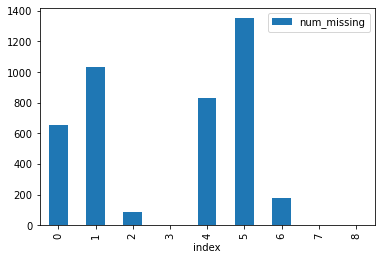

In [29]:
df2['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')
# drop rows with a lot of missing values.
ind_missing = df2[df2['num_missing'] >= 2].index
cds_few_minus_alcohol = df2.drop(ind_missing, axis=0)

ind_missing = df2[df2['num_missing'] >= 1].index
cds_few = df2.drop(ind_missing, axis=0)

In [30]:
to_drop = []
for col in df2.columns:
    if(col[-7:] == 'missing'):
        to_drop.append(col)
cds_few_minus_alcohol =cds_few_minus_alcohol.drop(to_drop, axis=1)
cds_few_minus_alcohol =cds_few_minus_alcohol.drop('abuso_alco', axis=1)

cds_few =cds_few.drop(to_drop, axis=1)

cds_imputed = cds_imputed.drop(to_drop, axis=1)

to_drop_plus = ['tran_depre', 'trast_personalidad', 'trast_bipolaridad', 'esquizofre', 'abuso_alco']
for col in to_drop_plus:
    to_drop.append(col)
to_drop

cds = df2.drop(to_drop, axis=1)

#### Todo bien, todo correcto

In [31]:
print(cds_few_minus_alcohol.isnull().sum().value_counts())
print(cds_few.isnull().sum().value_counts())
print(cds.isnull().sum().value_counts())
print(cds_imputed.isnull().sum().value_counts())

0    33
dtype: int64
0    34
dtype: int64
0    29
dtype: int64
0    34
dtype: int64


### Export

In [32]:
cds_few_minus_alcohol.to_csv('cds_few_minus_alcohol.csv',index=False)
cds_few_minus_alcohol

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,antec_v_a,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2050,20.0,1,1.0,1.0,9,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,1,0,0,0,0,0
2052,62.0,0,2.0,2.0,3,2.0,2.0,1.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0,0,0,0,0,1
2054,16.0,0,1.0,1.0,2,2.0,1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0,0,0,0,0,1
2059,23.0,0,1.0,1.0,9,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2.0,0,0,0,0,0,1
2060,26.0,1,1.0,3.0,3,2.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296,17.0,1,2.0,1.0,3,2.0,1.0,2.0,2.0,1.0,...,2.0,2.0,1.0,2.0,1,0,0,0,0,0
8297,17.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,1,0,0,0,0,0
8301,17.0,0,1.0,1.0,3,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2.0,0,0,0,1,0,0
8304,17.0,0,2.0,1.0,2,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,1.0,1,0,0,0,0,0


In [33]:
cds_few.to_csv('cds_few.csv',index=False)
cds_few

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,abuso_alco,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2050,20.0,1,1.0,1.0,9,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,1,0,0,0,0,0
2054,16.0,0,1.0,1.0,2,2.0,1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0,0,0,0,0,1
2059,23.0,0,1.0,1.0,9,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2.0,0,0,0,0,0,1
2060,26.0,1,1.0,3.0,3,2.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,0,0,0,0,0,1
2063,55.0,0,1.0,2.0,2,2.0,1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,19.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,1.0,...,2.0,1.0,2.0,2.0,1,0,0,0,0,0
4180,29.0,1,2.0,1.0,3,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,0,1,0,0,0,0
4183,23.0,0,1.0,1.0,3,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,0,0,0,0,0,1
4223,71.0,0,1.0,1.0,9,2.0,1.0,1.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0,0,0,1,0,0


In [34]:
cds.to_csv('cds.csv',index=False)
cds

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,antec_v_a,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2048,24.0,1,1.0,2.0,3,1.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,0,0,0,0,0,1
2049,30.0,0,2.0,1.0,2,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0,0,0,0,0,1
2050,20.0,1,1.0,1.0,9,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,1,0,0,0,0,0
2051,23.0,1,2.0,1.0,3,1.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2.0,0,0,0,0,0,1
2052,62.0,0,2.0,2.0,3,2.0,2.0,1.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,17.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,1,0,0,0,0,0
8311,17.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,1.0,2.0,1,0,0,0,0,0
8312,17.0,1,1.0,1.0,3,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,1,0,0,0,0,0
8313,17.0,1,2.0,1.0,9,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,1.0,2.0,1,0,0,0,0,0


In [35]:
cds_imputed.to_csv('cds_imputed.csv',index=False)
cds_imputed

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,abuso_alco,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
0,24,1,1,2,3,1,2,2,2,1,...,1,1,1,1,0,0,0,0,0,1
1,30,0,2,1,2,2,2,2,2,2,...,2,1,1,1,0,0,0,0,0,1
2,20,1,1,1,9,2,2,2,1,2,...,2,1,1,2,1,0,0,0,0,0
3,23,1,2,1,3,1,2,2,2,2,...,2,1,1,2,0,0,0,0,0,1
4,62,0,2,2,3,2,2,1,2,2,...,1,1,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,17,1,1,1,3,2,2,2,2,2,...,2,1,2,2,1,0,0,0,0,0
4142,17,1,1,1,3,2,2,2,2,1,...,2,2,1,2,1,0,0,0,0,0
4143,17,1,1,1,3,2,2,2,2,2,...,2,1,2,2,1,0,0,0,0,0
4144,17,1,2,1,9,2,2,2,2,1,...,2,2,1,2,1,0,0,0,0,0
